In [73]:
# Import the required libraries
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR

In [74]:
# Optimized hyperparameters and model structure
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The size of our model token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention
learning_rate = 1e-3  # 0.001
dropout = 0.1  # Dropout rate
max_iters = 10000  # Total of training iterations <- Change this to smaller number for testing
eval_interval = 50  # How often to evaluate
eval_iters = 20  # Number of iterations to average for evaluation
warmup_steps = 1000  # Learning rate warmup
weight_decay = 0.01  # Weight decay 
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if it's available.

# Set random seed
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [75]:
# Read and tokenize the text
with open('data/hello-algo-python.txt', 'r', encoding='utf-8') as f:
    text = f.read()

encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device)
max_token_value = tokenized_text.max().item()

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 163658
The maximum value in the tokenized text is: 100207


In [76]:
# Split data into training and validation sets
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [77]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [78]:
# Illustrate batches
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15
0  29129    220     21  57064     17   4996    241    230  13821    234  33904  49792  19967  53229  22649    198
1   9174  21405    220     24  57064     16  10447    236    108  41073  21990  76706  16325  40053  90070   9554
2   9554  52254  34171    198  27327   9174  15308    239  33976  93233    198    378    100    220  11589    224
3  42275  92019  88367  68379  96412  30358  59464  24186  72238   1811  15225  32626  70924  16325  32335  78659


In [79]:
# Define Token Embedding look-up table
token_embedding = nn.Embedding(max_token_value + 1, d_model)
print("Token Embedding: ", token_embedding)

Token Embedding:  Embedding(100208, 64)


In [80]:
# Get x and y embedding
x_batch_embedding = token_embedding(x_batch.data)
y_batch_embedding = token_embedding(y_batch.data)
x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [81]:
# Define Position Encoding 
position_encoding = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding[:, 0::2] = torch.sin(position * div_term)
position_encoding[:, 1::2] = torch.cos(position * div_term)
position_encoding = position_encoding.unsqueeze(0).expand(batch_size, -1, -1)

print("Position Encoding: ", position_encoding.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding[0].detach().cpu().numpy())

Position Encoding:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


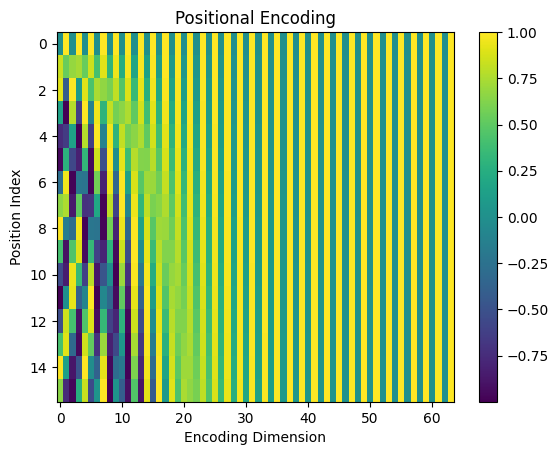

In [82]:
# Illustrate position encoding
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [83]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.371454,0.666364,0.551108,1.575531,-3.458015,0.042971,-0.651685,1.976073,-2.114418,2.051011,...,-1.852849,2.552283,2.626884,1.198766,-1.083803,0.718738,0.811715,0.368544,0.104440,1.734406
1,0.165456,0.609632,-0.134640,0.397936,0.739624,1.417673,0.954056,0.323163,-0.308004,1.532032,...,0.405213,-0.499148,-0.365290,1.453952,-0.274732,-0.924834,2.173576,2.523131,1.921272,1.818131
2,0.125355,-0.000731,0.037371,-1.446482,0.940949,1.161747,1.722864,-0.411779,0.730551,-0.390892,...,1.876488,0.260259,0.110734,1.030231,1.689757,2.555436,-0.118921,-0.695318,-0.155575,-0.680398
3,-0.515731,0.467517,0.578520,-0.779129,-0.347103,0.712041,2.742025,0.625562,0.027057,-0.873240,...,-0.713759,0.607169,-0.134389,0.429470,-0.894569,-0.097276,0.774381,2.266569,-0.057193,0.277749
4,1.177021,-0.350231,0.436598,0.601870,-0.262186,-0.087049,2.244025,-0.693388,-1.106638,-1.541670,...,0.556308,1.266560,0.421944,-0.240772,-2.262068,0.736214,0.906219,0.634014,-0.946256,2.540253
5,-0.911807,1.426584,-1.577907,-0.183022,0.881259,-1.579752,1.688784,-0.169934,2.051157,-1.397134,...,-1.412887,0.635251,-1.232550,-0.133652,-0.166301,1.656036,1.265085,1.320433,-0.124823,0.325603
6,2.176792,0.943169,-1.665840,1.749154,-0.785752,-0.647081,1.033444,-0.605052,1.294850,-0.442958,...,-1.185298,-1.590109,-0.676489,2.163973,1.860154,1.735575,2.207111,-0.208967,0.135401,0.907273
7,-0.639207,0.075740,-0.475496,0.429545,-1.546999,-1.912395,1.240461,0.109618,-0.147765,-1.231361,...,-0.778317,2.530048,-0.045974,1.793324,0.054270,1.003896,-0.166887,1.569345,-0.696155,1.736570
8,-0.992095,-1.142260,-0.210963,-1.139813,0.226930,0.439161,-0.100043,-1.278915,1.745685,-2.032526,...,0.562696,1.773631,-0.608448,-0.296847,-1.476440,-0.539014,-1.792841,0.321864,0.552891,0.761637
9,0.369225,-1.008031,0.683532,1.168696,0.194065,-1.462065,-1.531898,-0.219894,-0.496352,-1.577454,...,0.766135,0.762605,-0.938250,0.126783,-0.629409,1.446218,-0.731098,0.578192,-0.935227,1.093849


In [84]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [85]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -1.487548 -0.234531  0.692882  1.078502  0.945228 -0.985317  0.204150 -1.003744 -0.034240  1.660236  0.674554  0.351036 -0.241969 -0.423160  0.253677 -0.227870
1  0.988116  0.850795 -1.041386  1.083903  0.165555  0.362418 -0.931943 -0.468112 -0.095269  1.068265 -0.614306  1.428937 -1.301751  0.499383  0.292598 -0.730571
2  1.039841 -0.379177  1.302205 -1.062889 -0.426039 -1.065008  0.164211  0.436808 -0.613629 -0.680570  0.446016 -0.193759  0.712563  0.504403  1.414874 -0.532040
3 -0.014034 -0.462023  1.170167 -0.543329  1.003288 -1.226299  0.887032 -0.935340 -0.158748 -0.919571 -0.668356  0.473849  0.494291  0.855983  1.045000 -0.324132
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -1.687611 -0.742122  0.808

In [86]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.172212,-0.624809,-0.496842,-0.793205,-0.519591,-0.460345,-0.466078,-0.275057,0.681054,0.622272,0.176320,-0.007619,0.320209,0.328737,-0.917690,-0.528006
1,0.413693,-0.866354,-0.200037,-0.921241,-0.828050,-0.718129,-0.760000,-0.125814,0.497315,0.432745,0.173482,-0.442823,0.785280,0.228134,-1.192978,-0.419583
2,-0.393770,-0.250802,0.000512,0.232092,-0.222809,0.708082,0.330568,-0.142973,0.132869,-0.177599,-0.345664,-0.262727,0.076288,-0.189597,-0.061769,0.103149
3,0.602319,-0.025533,0.263439,-0.344880,-0.007844,-0.408720,0.008755,0.369043,-0.197613,-0.363762,-0.200632,0.116096,0.137126,0.232219,0.093902,0.234336
4,0.779160,-0.127883,0.170662,-0.403331,0.285143,0.029211,-0.106565,0.377237,0.470052,0.113290,0.119111,0.035009,0.918549,0.211324,-0.428957,-0.020791
5,0.047243,0.063052,0.051577,0.711537,-0.388818,0.116609,0.130376,0.313949,-0.012911,0.051184,-0.303024,-0.014479,0.614315,-0.201461,-0.198072,0.229938
6,0.168185,-0.193567,0.014731,0.051630,-0.061037,-0.017124,-0.242120,0.113318,0.003665,-0.194996,-0.219776,-0.238382,0.129041,0.081673,-0.330415,-0.005904
7,0.155224,0.086041,-0.097446,0.213779,-0.209598,0.468376,0.006640,0.311533,0.177246,0.444370,-0.130537,0.056039,0.932684,0.256892,-0.418445,0.219780
8,0.268795,0.154285,0.207541,0.507854,-0.200569,0.353589,0.144677,0.325252,-0.139359,0.184850,-0.223411,0.214627,0.846143,0.008468,0.155109,0.554432
9,0.358743,-0.167083,-0.189208,0.383453,-0.039161,-0.429987,-0.233965,0.115604,0.205102,0.551916,0.075114,0.255693,0.649751,0.031155,0.038183,0.176511


/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21704 (\N{CJK UNIFIED IDEOGRAPH-54C8}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24076 (\N{CJK UNIFIED IDEOGRAPH-5E0C}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyp

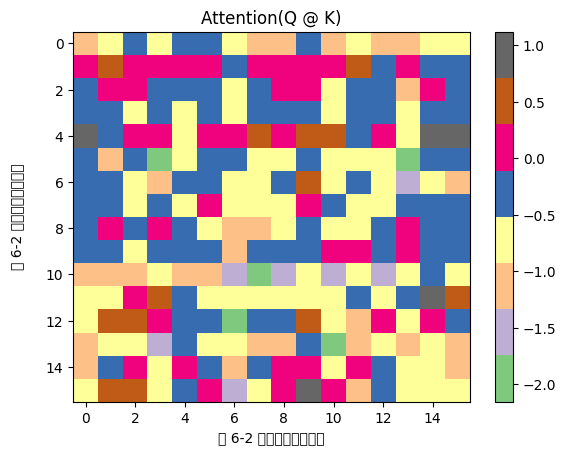

In [87]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.172212,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,0.413693,-0.866354,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.393770,-0.250802,0.000512,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.602319,-0.025533,0.263439,-0.344880,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.779160,-0.127883,0.170662,-0.403331,0.285143,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.047243,0.063052,0.051577,0.711537,-0.388818,0.116609,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.168185,-0.193567,0.014731,0.051630,-0.061037,-0.017124,-0.242120,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.155224,0.086041,-0.097446,0.213779,-0.209598,0.468376,0.006640,0.311533,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.268795,0.154285,0.207541,0.507854,-0.200569,0.353589,0.144677,0.325252,-0.139359,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.358743,-0.167083,-0.189208,0.383453,-0.039161,-0.429987,-0.233965,0.115604,0.205102,0.551916,-inf,-inf,-inf,-inf,-inf,-inf


/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21704 (\N{CJK UNIFIED IDEOGRAPH-54C8}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24076 (\N{CJK UNIFIED IDEOGRAPH-5E0C}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/home/bli/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyp

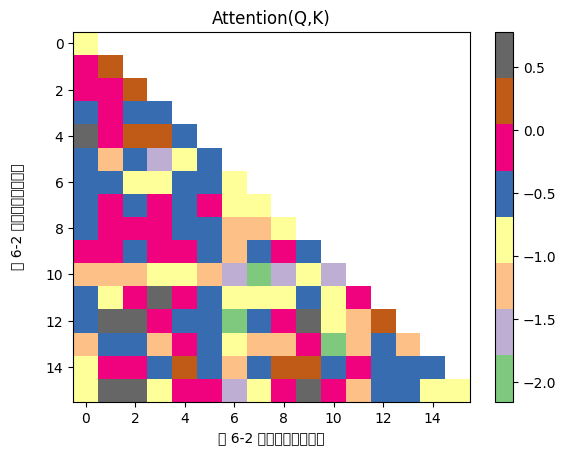

In [88]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [89]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.782458,0.217542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.274951,0.317209,0.407840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.379632,0.202624,0.270514,0.147231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.349093,0.140934,0.189965,0.107002,0.213006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.149660,0.152045,0.150310,0.290808,0.096767,0.160410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.174410,0.121469,0.149598,0.155221,0.138682,0.144908,0.115712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.127172,0.118672,0.098778,0.134841,0.088298,0.173937,0.109613,0.148688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.118729,0.105883,0.111674,0.150792,0.074253,0.129235,0.104870,0.125625,0.078940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.129399,0.076484,0.074810,0.132636,0.086921,0.058802,0.071535,0.101470,0.110970,0.156973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [90]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [91]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [92]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.338926,-0.257859,0.174093,0.370320,0.125614,-0.114844,-0.134822,-0.090320,-0.099488,0.400146,...,-0.338837,-0.439520,0.366060,0.864670,-0.901099,0.215541,0.857802,0.688212,-0.393279,-0.339254
1,-0.165828,-0.177295,0.178478,0.287049,-0.161857,0.202383,-0.045458,0.159066,-0.327573,0.203158,...,-0.319867,-0.163893,0.104966,0.586946,-0.854727,0.168187,0.741783,0.536659,-0.089178,0.086985
2,-0.212217,0.086618,-0.519061,-0.132300,-0.211486,-0.153817,-0.205719,0.589223,-0.223392,-0.161007,...,-0.185022,-0.219650,-0.123542,0.466728,-0.317648,0.159133,0.652747,0.217803,-0.161159,0.275474
3,-0.195697,0.094385,-0.144838,-0.079279,-0.077247,-0.073409,-0.040913,0.352656,-0.237344,0.001252,...,-0.137770,-0.104498,-0.051338,0.524846,-0.454543,0.130769,0.573387,0.279822,-0.071259,0.244816
4,-0.056937,0.191921,-0.392710,-0.098221,-0.118371,-0.165645,-0.118153,0.446161,-0.289252,0.006259,...,-0.118314,-0.046062,-0.085296,0.453957,-0.329687,0.004801,0.510952,0.406738,0.007610,0.264080
5,0.037321,0.067689,-0.310908,-0.262547,-0.193540,-0.225064,-0.078496,0.515051,-0.326450,-0.211733,...,0.057619,-0.043758,-0.230974,0.509728,-0.318112,0.075217,0.414036,0.335509,0.052558,0.365300
6,0.105023,0.053542,-0.354616,-0.180319,-0.041944,-0.307841,0.086549,0.512789,-0.312111,-0.183334,...,-0.002569,0.047832,-0.230673,0.382523,-0.257222,0.077283,0.438657,0.405399,-0.010048,0.358172
7,0.020309,-0.008964,-0.360682,-0.263208,-0.026215,-0.252801,0.118934,0.467218,-0.279294,-0.319654,...,-0.043366,-0.155777,-0.080387,0.446338,-0.225364,0.056079,0.378082,0.505737,-0.062069,0.359785
8,0.136539,-0.017953,-0.198227,-0.175536,-0.034077,-0.318020,-0.022508,0.380730,-0.213956,-0.325572,...,-0.099857,-0.241601,-0.076586,0.540948,-0.215424,-0.020901,0.306573,0.538398,-0.038958,0.263373
9,0.084787,0.062874,-0.330357,-0.203971,-0.046683,-0.274957,-0.037766,0.579607,-0.208446,-0.360094,...,-0.044066,-0.154603,-0.193799,0.377050,-0.129768,-0.030695,0.322743,0.438330,-0.047871,0.236090


In [93]:
# Add residual connection
output = output + X

In [94]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [95]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

In [96]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [97]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100198,100199,100200,100201,100202,100203,100204,100205,100206,100207
0,-0.606211,-0.076366,-0.171149,-0.467926,-0.295719,-0.267838,-0.591255,0.894743,0.236988,-0.307579,...,0.649029,0.385121,0.284425,0.578759,-0.004243,-0.571605,0.384719,0.499626,-0.328009,0.202228
1,-0.353544,1.037682,0.218772,-0.530124,0.533981,-0.280828,0.171343,0.569967,-0.669091,0.243184,...,-0.315668,0.747396,1.019579,1.768657,-0.449081,0.254339,0.104317,0.136267,0.258643,-0.120248
2,0.034831,0.220504,-1.061961,-1.823815,1.041244,0.616927,0.254313,1.068643,1.659419,-0.183433,...,0.423845,-0.155477,-0.005079,0.986222,0.229694,0.819086,-0.547415,-0.210146,-0.431312,0.249917
3,-0.436902,-0.627069,0.365103,-0.690041,-0.005450,0.454040,-0.150830,1.008529,-0.092932,0.375176,...,-0.339546,0.213818,0.298766,0.657661,0.365668,0.369432,1.122962,-0.638822,0.137203,0.584700
4,-0.230926,-0.080270,-0.043620,0.392342,-0.268220,0.070574,-0.666868,0.750174,1.009763,0.009322,...,-0.300845,1.076200,0.674656,0.337911,0.152658,0.695660,0.592182,0.178597,-0.199216,0.266085
5,0.701168,0.649424,-1.035326,-0.704001,0.350198,0.548784,1.086190,-0.455231,0.165602,0.193318,...,0.525406,0.424453,0.739065,0.730836,0.683392,0.478205,0.139179,-1.284765,-1.107249,0.889946
6,-0.018817,0.812075,-0.541535,0.662935,0.456584,0.472764,0.527924,1.043513,0.528855,0.446889,...,-0.562089,0.719523,0.138172,0.734486,-0.511441,-0.469776,-0.559888,-0.687331,-0.851659,0.378216
7,-0.104843,1.082201,-0.235579,-1.203428,0.584066,0.262624,0.311916,-0.167234,-0.910444,0.178879,...,0.783530,-0.193752,0.409271,-0.092114,0.232981,-0.201507,-0.157343,-0.736042,-0.687312,0.608740
8,0.444507,0.814668,0.016382,-0.255835,-0.340411,0.718239,0.638193,0.885195,-0.486264,-0.404232,...,-0.119042,-0.325529,0.605860,0.994214,0.362332,0.354794,-0.224990,0.106117,-0.990349,-0.303454
9,0.344752,0.162577,-0.824332,-0.031393,-1.387215,-0.061302,0.837665,1.479689,0.386194,0.238760,...,0.613591,0.874444,0.176301,0.613332,0.300306,-0.286623,-0.133605,-0.486352,-0.684135,0.654847


In [98]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100198,100199,100200,100201,100202,100203,100204,100205,100206,100207
0,0.000005,0.000008,0.000007,0.000005,0.000006,0.000006,0.000005,0.000021,0.000011,0.000006,...,0.000016,0.000012,0.000011,0.000015,0.000008,0.000005,0.000012,0.000014,0.000006,0.000010
1,0.000006,0.000024,0.000010,0.000005,0.000014,0.000006,0.000010,0.000015,0.000004,0.000011,...,0.000006,0.000018,0.000023,0.000049,0.000005,0.000011,0.000009,0.000010,0.000011,0.000007
2,0.000009,0.000011,0.000003,0.000001,0.000024,0.000016,0.000011,0.000025,0.000044,0.000007,...,0.000013,0.000007,0.000008,0.000023,0.000011,0.000019,0.000005,0.000007,0.000005,0.000011
3,0.000005,0.000005,0.000012,0.000004,0.000008,0.000013,0.000007,0.000023,0.000008,0.000012,...,0.000006,0.000010,0.000011,0.000016,0.000012,0.000012,0.000026,0.000004,0.000010,0.000015
4,0.000007,0.000008,0.000008,0.000012,0.000006,0.000009,0.000004,0.000018,0.000023,0.000009,...,0.000006,0.000025,0.000017,0.000012,0.000010,0.000017,0.000015,0.000010,0.000007,0.000011
5,0.000017,0.000016,0.000003,0.000004,0.000012,0.000015,0.000025,0.000005,0.000010,0.000010,...,0.000014,0.000013,0.000018,0.000018,0.000017,0.000014,0.000010,0.000002,0.000003,0.000021
6,0.000008,0.000019,0.000005,0.000016,0.000013,0.000014,0.000014,0.000024,0.000014,0.000013,...,0.000005,0.000017,0.000010,0.000018,0.000005,0.000005,0.000005,0.000004,0.000004,0.000012
7,0.000008,0.000025,0.000007,0.000003,0.000015,0.000011,0.000012,0.000007,0.000003,0.000010,...,0.000018,0.000007,0.000013,0.000008,0.000011,0.000007,0.000007,0.000004,0.000004,0.000016
8,0.000013,0.000019,0.000009,0.000007,0.000006,0.000017,0.000016,0.000020,0.000005,0.000006,...,0.000007,0.000006,0.000015,0.000023,0.000012,0.000012,0.000007,0.000009,0.000003,0.000006
9,0.000012,0.000010,0.000004,0.000008,0.000002,0.000008,0.000020,0.000037,0.000012,0.000011,...,0.000016,0.000020,0.000010,0.000016,0.000011,0.000006,0.000007,0.000005,0.000004,0.000016


In [99]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

'aris'

In [100]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

'图 6‑2 哈希函数工作原理\n'